In [609]:
reset -fs

In [612]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.preprocessing import OneHotEncoder
from sklearn import linear_model, tree
from sklearn.model_selection import train_test_split,cross_val_score, cross_val_predict,GridSearchCV,RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
 
from sklearn.metrics import roc_curve, confusion_matrix,precision_recall_curve,roc_auc_score
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score 

import xgboost as xgb # note for installation use py-xgboost in conda

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.tree import DecisionTreeClassifier

%matplotlib inline
plt.style.use('seaborn')
np.random.seed(42)

In [1146]:
def get_col_descr(feature):
    return column_description[column_description.row == feature].loc[:, 'description'].tolist()

def isNaN(num):
    return num != num

def hist_print(data1, data0):
    plt.hist(data1, alpha=0.4, label='target: 1', bins=20, weights=np.ones(len(data1)) / len(data1))
    plt.hist(data0, alpha=0.4, label='target: 0', bins=20, weights=np.ones(len(data0)) / len(data0))
    plt.legend(loc='best')
    plt.show()

In [614]:
train = pd.read_csv('application_train.csv')
test = pd.read_csv('application_test.csv')
test['target'] = -999
train.columns = train.columns.str.lower()
test.columns = test.columns.str.lower()

train['dataset'] = 'train'
test['dataset'] = 'test'

X = pd.concat([train,test],sort=True)

In [448]:
num_features = list(X.columns[X.dtypes!=object])
num_features.remove('target')
cat_features = list(X.columns[X.dtypes==object])

In [619]:
cols = pd.read_csv('HomeCredit_columns_description.csv', encoding= 'unicode_escape')
column_description = cols[cols.Table == 'application_{train|test}.csv']
column_description.columns = column_description.columns.str.lower()
column_description.drop(['unnamed: 0', 'table'], axis=1, inplace=True)
column_description['row'] = column_description['row'].apply(lambda x: x.lower())
column_description.head(2)

/Users/johannespastorek/opt/anaconda3/envs/nf/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/Users/johannespastorek/opt/anaconda3/envs/nf/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


,row,description,special
0,sk_id_curr,ID of loan in our sample,NaN
1,target,Target variable (1 - client with payment diffi...,NaN


In [450]:
special_col = column_description.special.unique()
special_col

array([nan, 'normalized ', 'time only relative to the application',
       'rounded', 'normalized'], dtype=object)

In [451]:
column_description[column_description.special == special_col[2]]

,row,description,special
17,days_birth,Client's age in days at the time of application,time only relative to the application
18,days_employed,How many days before the application the perso...,time only relative to the application
19,days_registration,How many days before the application did clien...,time only relative to the application
20,days_id_publish,How many days before the application did clien...,time only relative to the application


In [452]:
column_description[column_description.special == special_col[1]]

,row,description,special
16,region_population_relative,Normalized population of region where client l...,normalized


In [453]:
column_description[column_description.special == special_col[3]]

,row,description,special
33,hour_appr_process_start,Approximately at what hour did the client appl...,rounded


In [454]:
norm_df = column_description[column_description.special == special_col[4]] #normalized
X[norm_df.row.tolist() + ['target']].corr().target.sort_values(ascending=False)

target                          1.000000
ext_source_3                    0.019079
years_build_medi                0.004344
years_build_mode                0.004129
years_build_avg                 0.004087
ext_source_1                    0.001624
nonlivingapartments_mode       -0.002111
nonlivingapartments_medi       -0.002401
nonlivingapartments_avg        -0.003073
landarea_avg                   -0.003683
landarea_medi                  -0.003815
landarea_mode                  -0.004069
nonlivingarea_avg              -0.005139
nonlivingarea_medi             -0.005240
nonlivingarea_mode             -0.005617
basementarea_mode              -0.006052
years_beginexpluatation_medi   -0.006367
years_beginexpluatation_avg    -0.006578
ext_source_2                   -0.006687
basementarea_medi              -0.006712
years_beginexpluatation_mode   -0.006769
entrances_mode                 -0.006796
basementarea_avg               -0.006897
entrances_medi                 -0.006908
entrances_avg   

In [455]:
#X[norm_df.row.tolist()].info()
test[norm_df.row.tolist()].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48744 entries, 0 to 48743
Data columns (total 50 columns):
ext_source_1                    28212 non-null float64
ext_source_2                    48736 non-null float64
ext_source_3                    40076 non-null float64
apartments_avg                  24857 non-null float64
basementarea_avg                21103 non-null float64
years_beginexpluatation_avg     25888 non-null float64
years_build_avg                 16926 non-null float64
commonarea_avg                  15249 non-null float64
elevators_avg                   23555 non-null float64
entrances_avg                   25165 non-null float64
floorsmax_avg                   25423 non-null float64
floorsmin_avg                   16278 non-null float64
landarea_avg                    20490 non-null float64
livingapartments_avg            15964 non-null float64
livingarea_avg                  25192 non-null float64
nonlivingapartments_avg         15397 non-null float64
nonlivingar

In [456]:
get_col_descr('days_birth')

["Client's age in days at the time of application"]

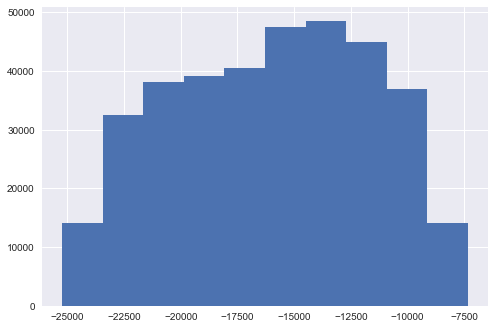

In [457]:
X.days_birth.hist()

In [458]:
X.days_birth.describe()

count    356255.000000
mean     -16041.248841
std        4358.803980
min      -25229.000000
25%      -19676.000000
50%      -15755.000000
75%      -12425.000000
max       -7338.000000
Name: days_birth, dtype: float64

In [459]:
print('oldest: ' + str(int(X.days_birth.min() / -365)))
print('youngest: ' + str(int(X.days_birth.max() / -365)))

oldest: 69
youngest: 20


In [460]:
X['age'] = X['days_birth'].apply(lambda x: int(x / -365))

In [461]:
X.drop('days_birth', axis=1, inplace=True)

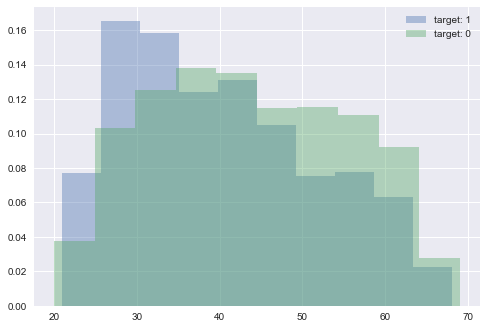

In [462]:
plt1 = X[(X.dataset == 'train') & (X.target == 1)].age
plt0 = X[(X.dataset == 'train') & (X.target == 0)].age
hist_print(plt1, plt0)

In [463]:
get_col_descr('days_employed')

['How many days before the application the person started current employment']

In [464]:
X.days_employed.describe()

count    356255.000000
mean      64317.231413
std      141705.532576
min      -17912.000000
25%       -2781.000000
50%       -1224.000000
75%        -290.000000
max      365243.000000
Name: days_employed, dtype: float64

In [465]:
print('oldest: ' + str(int(X.days_employed.min() / -365)))
print('youngest: ' + str(int(X.days_employed.max() / -365)))

oldest: 49
youngest: -1000


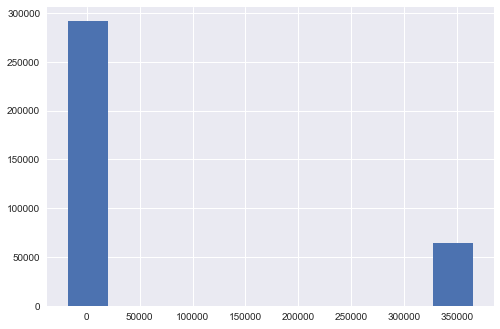

In [466]:
X.days_employed.hist()

In [467]:
X['employed'] = X['days_employed'].apply(lambda x: int(x / -365))
X.drop('days_employed', axis=1, inplace=True)

In [468]:
X = X[X['employed'] != -1000]

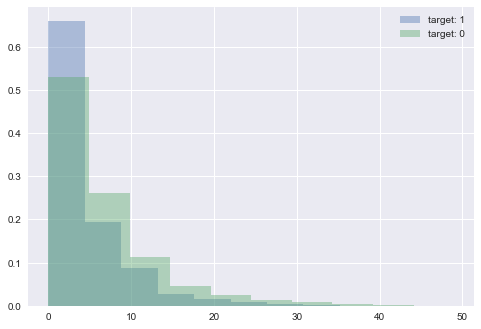

In [469]:
plt0 = X[(X.dataset == 'train') & (X.employed >= 0) & (X.target == 0)].employed
plt1 = X[(X.dataset == 'train') & (X.employed >= 0) & (X.target == 1)].employed
hist_print(plt1, plt0)

In [470]:
get_col_descr('days_registration')

['How many days before the application did client change his registration']

In [471]:
X.days_registration.describe()

count    291607.000000
mean      -4631.177527
std        3253.258995
min      -22928.000000
25%       -6947.000000
50%       -4263.000000
75%       -1830.000000
max           0.000000
Name: days_registration, dtype: float64

In [472]:
print('longest: ' + str(int(X.days_registration.min() / -365)))
print('shortest: ' + str(int(X.days_registration.max() / -365)))

longest: 62
shortest: 0


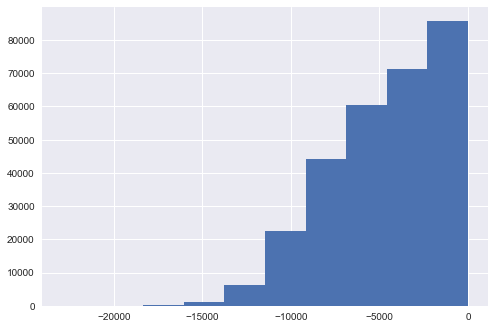

In [473]:
X.days_registration.hist()

In [474]:
X['reg_changed'] = X['days_registration'].apply(lambda x: int(x / -365))
X.drop('days_registration', axis=1, inplace=True)

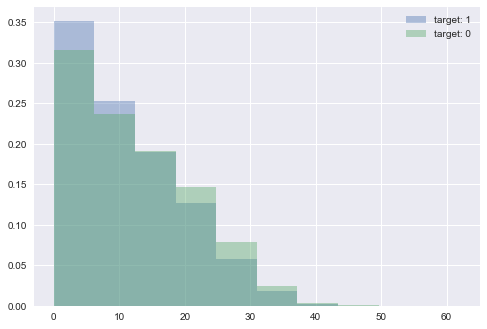

In [475]:
plt0 = X[(X.dataset == 'train') & (X.target == 0)].reg_changed
plt1 = X[(X.dataset == 'train') & (X.target == 1)].reg_changed
hist_print(plt1, plt0)

In [476]:
get_col_descr('days_id_publish')

['How many days before the application did client change the identity document with which he applied for the loan']

In [477]:
X.days_id_publish.describe()

count    291607.000000
mean      -2805.639799
std        1523.111046
min       -7197.000000
25%       -4194.000000
50%       -2882.000000
75%       -1482.000000
max           0.000000
Name: days_id_publish, dtype: float64

In [478]:
print('longest: ' + str(int(X.days_id_publish.min() / -365)))
print('shortest: ' + str(int(X.days_id_publish.max() / -365)))

longest: 19
shortest: 0


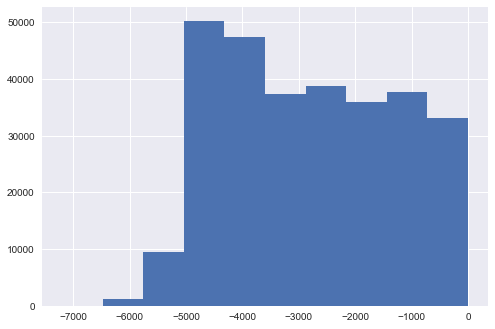

In [479]:
X.days_id_publish.hist()

In [480]:
X['id_changed'] = X['days_id_publish'].apply(lambda x: int(x / -365))
X.drop('days_id_publish', axis=1, inplace=True)

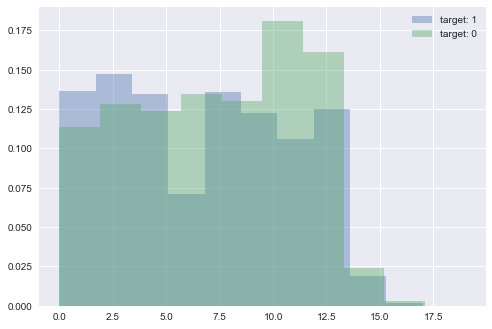

In [481]:
plt0 = X[(X.dataset == 'train') & (X.target == 0)].id_changed
plt1 = X[(X.dataset == 'train') & (X.target == 1)].id_changed
hist_print(plt1, plt0)

In [482]:
get_col_descr('region_population_relative')

['Normalized population of region where client lives (higher number means the client lives in more populated region)']

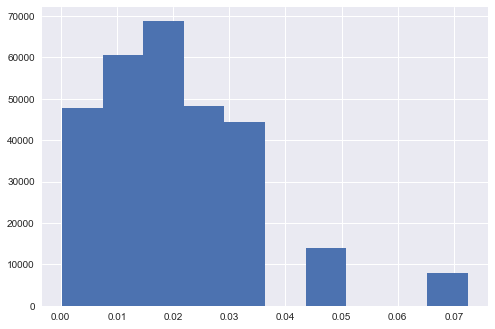

In [483]:
X.region_population_relative.hist()

In [484]:
X.region_population_relative.describe()

count    291607.000000
mean          0.020939
std           0.013948
min           0.000253
25%           0.010006
50%           0.018850
75%           0.028663
max           0.072508
Name: region_population_relative, dtype: float64

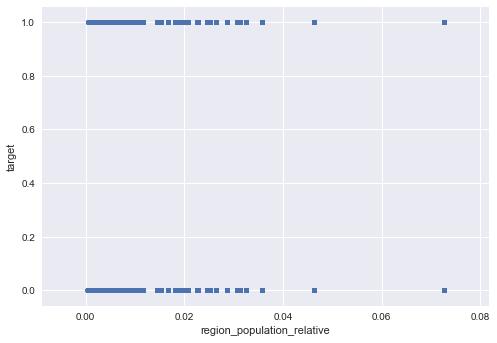

In [485]:
train.plot(kind='scatter', x='region_population_relative', y='target')

In [486]:
get_col_descr('hour_appr_process_start')

['Approximately at what hour did the client apply for the loan']

In [487]:
X.hour_appr_process_start.describe()

count    291607.000000
mean         12.194841
std           3.300591
min           0.000000
25%          10.000000
50%          12.000000
75%          15.000000
max          23.000000
Name: hour_appr_process_start, dtype: float64

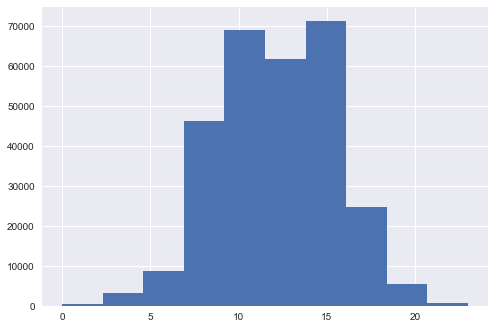

In [488]:
X.hour_appr_process_start.hist()

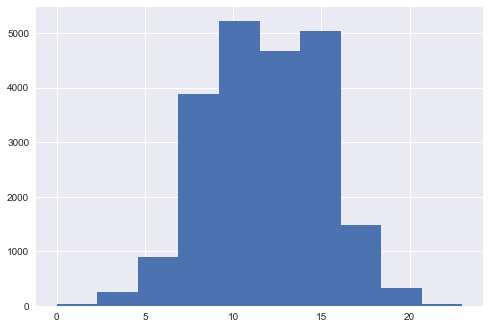

In [489]:
X[(X.dataset == 'train') & (X.target == 1)].hour_appr_process_start.hist()

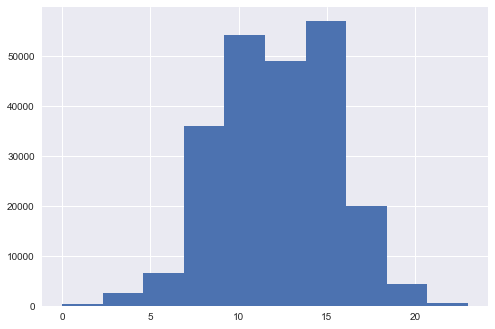

In [490]:
X[(X.dataset == 'train') & (X.target == 0)].hour_appr_process_start.hist()

In [491]:
norm_df = column_description[column_description.special == special_col[4]]

In [1169]:
X.occupation_type.unique()

array(['Laborers', 'Core staff', 'Accountants', 'Managers', 'Drivers',
       'Sales staff', 'Cleaning staff', 'Cooking staff', 'missing',
       'Private service staff', 'Medicine staff', 'Security staff',
       'High skill tech staff', 'Waiters/barmen staff',
       'Low-skill Laborers', 'Realty agents', 'Secretaries', 'IT staff',
       'HR staff'], dtype=object)

In [493]:
sum(train.target) / len(train)

0.08072881945686496

In [494]:
#sum(train[isNaN(train.ext_source_1) == True].target)
len(train[isNaN(train.ext_source_1) == True]) / len(train)
sum(train[isNaN(train.ext_source_1) == True].target) / len(train[isNaN(train.ext_source_1) == True])

0.08519535350505832

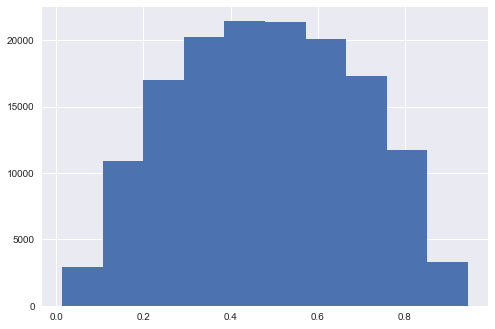

In [495]:
X.ext_source_1.hist()

/Users/johannespastorek/opt/anaconda3/envs/nf/lib/python3.6/site-packages/numpy/lib/histograms.py:834: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/johannespastorek/opt/anaconda3/envs/nf/lib/python3.6/site-packages/numpy/lib/histograms.py:835: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


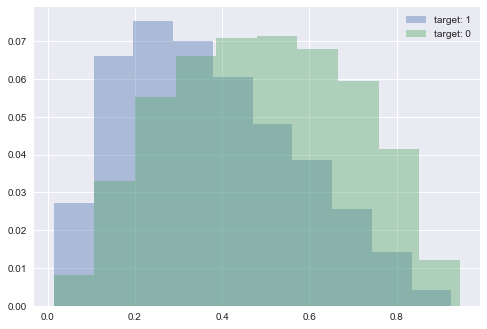

In [496]:
plt0 = X[(X.dataset == 'train') & (X.target == 0)].ext_source_1
plt1 = X[(X.dataset == 'train') & (X.target == 1)].ext_source_1
hist_print(plt1, plt0)

In [805]:
X1 = X[['target', 'ext_source_1', 'dataset']]
X1['isnull'] =  pd.isnull(X['ext_source_1']).tolist()
X1['isnull'] = X1['isnull'].astype(int)

/Users/johannespastorek/opt/anaconda3/envs/nf/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/johannespastorek/opt/anaconda3/envs/nf/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


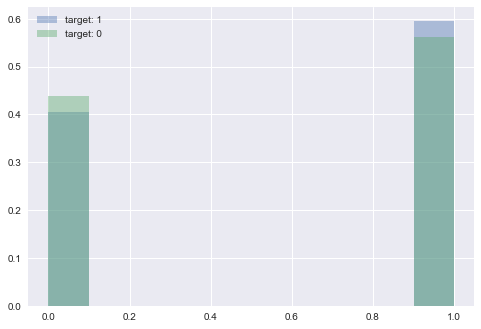

In [807]:
plt0 = X1[(X1.dataset == 'train') & (X.target == 0)]['isnull']
plt1 = X1[(X1.dataset == 'train') & (X.target == 1)]['isnull']
hist_print(plt1, plt0)

In [497]:
get_col_descr('ext_source_2')

['Normalized score from external data source']

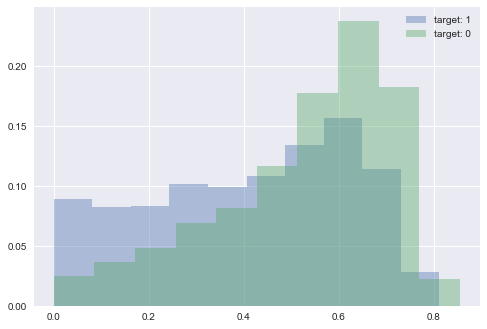

In [498]:
plt0 = X[(X.dataset == 'train') & (X.target == 0)].ext_source_2
plt1 = X[(X.dataset == 'train') & (X.target == 1)].ext_source_2
hist_print(plt1, plt0)

In [499]:
get_col_descr('ext_source_3')

['Normalized score from external data source']

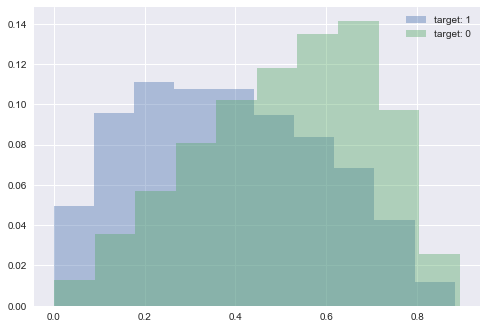

In [500]:
plt0 = X[(X.dataset == 'train') & (X.target == 0)].ext_source_3
plt1 = X[(X.dataset == 'train') & (X.target == 1)].ext_source_3
hist_print(plt1, plt0)

In [501]:
get_col_descr('apartments_avg')

['Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor']

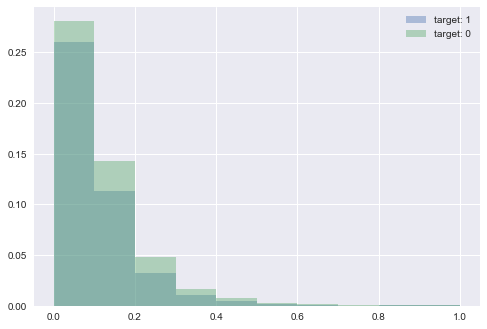

In [502]:
plt0 = X[(X.dataset == 'train') & (X.target == 0)].apartments_avg
plt1 = X[(X.dataset == 'train') & (X.target == 1)].apartments_avg
hist_print(plt1, plt0)

In [503]:
get_col_descr('livingapartments_avg')

['Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor']

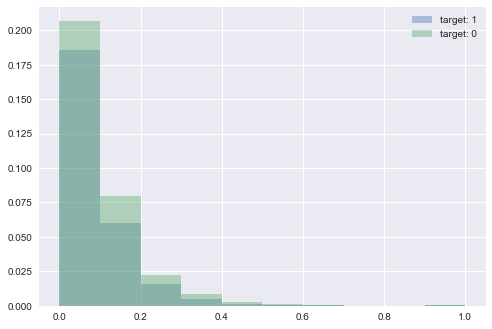

In [504]:
plt0 = X[(X.dataset == 'train') & (X.target == 0)].livingapartments_avg
plt1 = X[(X.dataset == 'train') & (X.target == 1)].livingapartments_avg
hist_print(plt1, plt0)

In [505]:
num_features = list(X.columns[X.dtypes!=object])
cat_features = list(X.columns[X.dtypes==object])
cat_features

['code_gender',
 'dataset',
 'emergencystate_mode',
 'flag_own_car',
 'flag_own_realty',
 'fondkapremont_mode',
 'housetype_mode',
 'name_contract_type',
 'name_education_type',
 'name_family_status',
 'name_housing_type',
 'name_income_type',
 'name_type_suite',
 'occupation_type',
 'organization_type',
 'wallsmaterial_mode',
 'weekday_appr_process_start']

In [506]:
X['code_gender'] = X['code_gender'].apply(lambda x: float('NaN') if x == 'XNA' else x)
X['code_gender'] = X.code_gender.map({'F': 0, 'M': 1, })

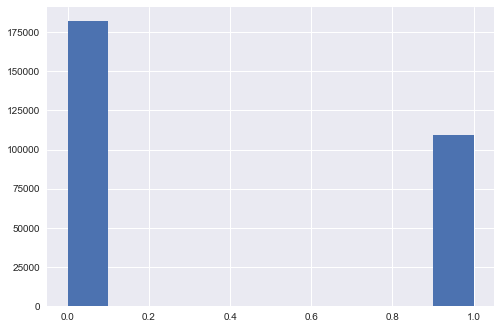

In [507]:
X.code_gender.hist()

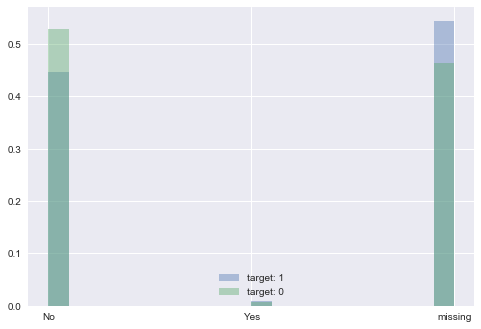

In [1178]:
plt0 = X[(X.dataset == 'train') & (X.target == 0)].emergencystate_mode
plt1 = X[(X.dataset == 'train') & (X.target == 1)].emergencystate_mode
hist_print(plt1, plt0)

In [1171]:
get_col_descr('amt_credit')

['Credit amount of the loan']

In [ ]:
X.emergencystate_mode.fillna('missing', inplace=True)

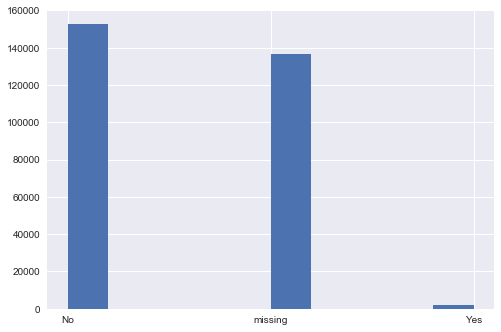

In [525]:
X.emergencystate_mode.hist()

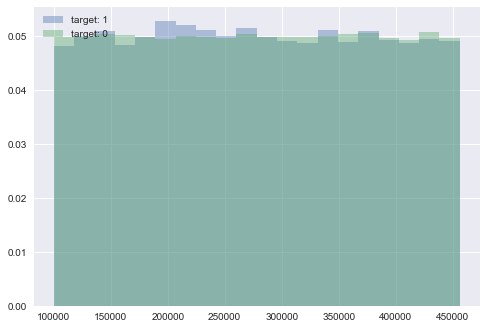

In [1177]:
plt0 = X[(X.dataset == 'train') & (X.target == 0)].sk_id_curr 
plt1 = X[(X.dataset == 'train') & (X.target == 1)].sk_id_curr 
hist_print(plt1, plt0)

In [529]:
get_col_descr('flag_own_car')

['Flag if the client owns a car']

In [565]:
for i in cat_features:
    print(train[i].unique())

['M' 'F' 'XNA']
['train']
['No' nan 'Yes']
['N' 'Y']
['Y' 'N']
['reg oper account' nan 'org spec account' 'reg oper spec account'
 'not specified']
['block of flats' nan 'terraced house' 'specific housing']
['Cash loans' 'Revolving loans']
['Secondary / secondary special' 'Higher education' 'Incomplete higher'
 'Lower secondary' 'Academic degree']
['Single / not married' 'Married' 'Civil marriage' 'Widow' 'Separated'
 'Unknown']
['House / apartment' 'Rented apartment' 'With parents'
 'Municipal apartment' 'Office apartment' 'Co-op apartment']
['Working' 'State servant' 'Commercial associate' 'Pensioner' 'Unemployed'
 'Student' 'Businessman' 'Maternity leave']
['Unaccompanied' 'Family' 'Spouse, partner' 'Children' 'Other_A' nan
 'Other_B' 'Group of people']
['Laborers' 'Core staff' 'Accountants' 'Managers' nan 'Drivers'
 'Sales staff' 'Cleaning staff' 'Cooking staff' 'Private service staff'
 'Medicine staff' 'Security staff' 'High skill tech staff'
 'Waiters/barmen staff' 'Low-skill Lab

In [1103]:
num_features = list(X.columns[X.dtypes!=object])
cat_features = list(X.columns[X.dtypes==object])
X[cat_features] = X[cat_features].fillna('missing')

In [1127]:
X['fond_nan'] = X['fondkapremont_mode'].apply(lambda x: 0 if x == 'missing' else 1)
X['housetype_nan'] = X['housetype_mode'].apply(lambda x: 0 if x == 'missing' else 1)
#X['secondary_educ'] = X['name_education_type'].apply(lambda x: 1 if x == 'Secondary / secondary special' else 0)
X['higher_educ'] = X['name_education_type'].apply(lambda x: 1 if (x == 'Higher education') | (x == 'Academic degree')  else 0)

In [1133]:
X['no_own_prop'] = X['name_housing_type'].apply(lambda x: 
                                                1 if (x == 'With parents') | (x == 'Rented apartment')  else 0
                                               )

In [1141]:
X['blue_collar'] = X['name_income_type'].apply(lambda x: 1 if x == 'Working' else 0)


In [1145]:
X['occupation_type'].unique()

array(['Laborers', 'Core staff', 'Accountants', 'Managers', 'Drivers',
       'Sales staff', 'Cleaning staff', 'Cooking staff', 'missing',
       'Private service staff', 'Medicine staff', 'Security staff',
       'High skill tech staff', 'Waiters/barmen staff',
       'Low-skill Laborers', 'Realty agents', 'Secretaries', 'IT staff',
       'HR staff'], dtype=object)

In [1158]:
X['blue_collar2'] = X['occupation_type'].apply(lambda x: 
                                               1 if (x == 'Laborers') |
                                                    (x == 'Cooking staff') |
                                                    (x == 'Sales staff') |
                                                    (x == 'Drivers') |
                                                    (x == 'Security staff') |
                                                    (x == 'Waiters/barmen staff') |
                                                    (x == 'Low-skill Laborers') |
                                                    (x == 'Secretaries') |
                                                    (x == 'missing')
                                               else 0
                                              )

In [1162]:
X['organization_type'].unique()

array(['Business Entity Type 3', 'School', 'Government', 'Religion',
       'Other', 'Electricity', 'Medicine', 'Business Entity Type 2',
       'Self-employed', 'Transport: type 2', 'Construction', 'Housing',
       'Kindergarten', 'Trade: type 7', 'Industry: type 11', 'Military',
       'Services', 'Security Ministries', 'Transport: type 4',
       'Industry: type 1', 'Emergency', 'Security', 'Trade: type 2',
       'University', 'Transport: type 3', 'Police',
       'Business Entity Type 1', 'Postal', 'Industry: type 4',
       'Agriculture', 'Restaurant', 'Culture', 'Hotel',
       'Industry: type 7', 'Trade: type 3', 'Industry: type 3', 'Bank',
       'Industry: type 9', 'Insurance', 'Trade: type 6',
       'Industry: type 2', 'Transport: type 1', 'Industry: type 12',
       'Mobile', 'Trade: type 1', 'Industry: type 5', 'Industry: type 10',
       'Legal Services', 'Advertising', 'Trade: type 5', 'Cleaning',
       'Industry: type 13', 'Trade: type 4', 'Telecom',
       'Industry

['Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor']


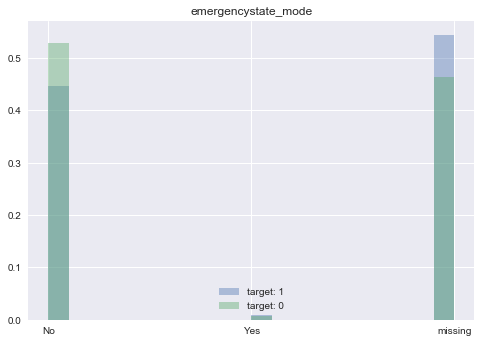

In [1167]:
i = 2
print(get_col_descr(cat_features[i]))
feature = cat_features[i]
#feature = 'blue_collar2'
X[feature].fillna('missing', inplace=True)
#plt.figure(figsize=(20, 3))
plt0 = X[(X.dataset == 'train') & (X.target == 0)][feature]
plt1 = X[(X.dataset == 'train') & (X.target == 1)][feature]
plt.title(str(cat_features[i]))
hist_print(plt1, plt0)

In [861]:
X['app_nan'] = X['apartments_medi'].apply(lambda x: 0 if isNaN(x) == True else 1)

In [929]:
X['base_nan'] = X['basementarea_medi'].apply(lambda x: 0 if isNaN(x) == True else 1)

array([1, 0])

In [1085]:
X['elev_nan'] = X['elevators_medi'].apply(lambda x: 0 if isNaN(x) == True else 1)
X['entr_nan'] = X['entrances_medi'].apply(lambda x: 0 if isNaN(x) == True else 1)
X['floorsmax_nan'] = X['floorsmax_medi'].apply(lambda x: 0 if isNaN(x) == True else 1)
X['floorsmin_nan'] = X['floorsmin_medi'].apply(lambda x: 0 if isNaN(x) == True else 1)
X['landarea_nan'] = X['landarea_medi'].apply(lambda x: 0 if isNaN(x) == True else 1)
X['living_nan'] = X['livingapartments_medi'].apply(lambda x: 0 if isNaN(x) == True else 1)
X['area_nan'] = X['livingarea_medi'].apply(lambda x: 0 if isNaN(x) == True else 1)
X['nonliving_nan'] = X['nonlivingapartments_medi'].apply(lambda x: 0 if isNaN(x) == True else 1)
X['nonarea_nan'] = X['nonlivingarea_medi'].apply(lambda x: 0 if isNaN(x) == True else 1)
X['years_nan'] = X['years_build_medi'].apply(lambda x: 0 if isNaN(x) == True else 1)

X['complete'] = X['years_nan'] + X['nonarea_nan'] + X['nonliving_nan'] + X['area_nan'] + X['living_nan'] + \
                X['landarea_nan'] + X['floorsmin_nan'] + X['floorsmax_nan'] + X['entr_nan'] + X['elev_nan']

In [1087]:
X['complete'] = X['complete'].apply(lambda x: 1 if x == 0 else 0)

In [877]:
X['common_nan'] = X['commonarea_medi'].apply(lambda x: 0 if isNaN(x) == True else 1)

In [893]:
X['age'] = X['days_birth'].apply(lambda x: int(x / -365))
X['employed'] = X['days_employed'].apply(lambda x: int(x / -365))
X = X[X['employed'] != -1000]

In [1037]:
X['age_cat'] = pd.cut(X['age'], bins=[0,35,45,999], labels=['Young', 'Adult', 'Elder'])
X['emp_cat'] = pd.cut(X['employed'], bins=[0,4,999], labels=[0, 1])


In [995]:
#X['id_publish'] = X['days_id_publish'].apply(lambda x: int(x / -365))


In [951]:
X['days_last_phone_change'] = X['days_last_phone_change'].fillna(9999)
X['phones_change'] = X['days_last_phone_change'].apply(lambda x: int(x / -365))

In [956]:
X['registration'] = X['days_registration'].apply(lambda x: int(x / -365))

In [971]:
X['ext_source_1_dum'] = pd.cut(X['ext_source_1'], bins=[0,.4,1], labels=[0, 1])

In [1043]:
X['car_cat'] = X['own_car_age'].apply(lambda x: 0 if x <= 9 else 1)

['Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor']


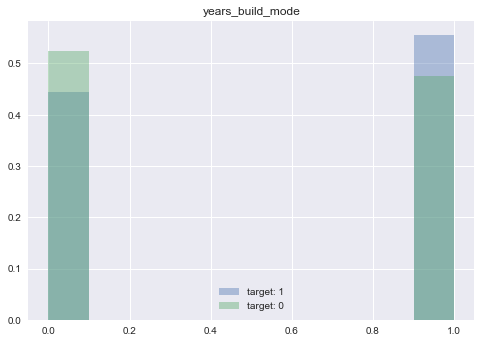

In [1088]:
i = 105
print(get_col_descr(num_features[i]))
feature = num_features[i]
feature = 'complete'
#X[feature].fillna('missing', inplace=True)
plt0 = X[(X.dataset == 'train') & (X.target == 0)][feature]
plt1 = X[(X.dataset == 'train') & (X.target == 1)][feature]
plt.title(str(num_features[i]))
hist_print(plt1, plt0)

In [872]:
train[num_features[16]].describe()

count    304809.000000
mean          0.416274
std           0.721454
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max          19.000000
Name: cnt_children, dtype: float64

In [854]:
train[num_features].info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 304809 entries, 0 to 307510
Data columns (total 106 columns):
amt_annuity                     304797 non-null float64
amt_credit                      304809 non-null float64
amt_goods_price                 304533 non-null float64
amt_income_total                304809 non-null float64
amt_req_credit_bureau_day       263566 non-null float64
amt_req_credit_bureau_hour      263566 non-null float64
amt_req_credit_bureau_mon       263566 non-null float64
amt_req_credit_bureau_qrt       263566 non-null float64
amt_req_credit_bureau_week      263566 non-null float64
amt_req_credit_bureau_year      263566 non-null float64
apartments_avg                  149621 non-null float64
apartments_medi                 149621 non-null float64
apartments_mode                 149621 non-null float64
basementarea_avg                125956 non-null float64
basementarea_medi               125956 non-null float64
basementarea_mode               125956 non-null 

In [626]:
missing = pd.DataFrame(X[num_features].isnull().sum(),columns=['Number'])
missing['Percentage'] = round(missing.Number/X[num_features].shape[0]*100,2)
missing[missing.Percentage!=0]

,Number,Percentage
amt_annuity,36,0.01
amt_goods_price,278,0.08
amt_req_credit_bureau_day,47568,13.35
amt_req_credit_bureau_hour,47568,13.35
amt_req_credit_bureau_mon,47568,13.35
amt_req_credit_bureau_qrt,47568,13.35
amt_req_credit_bureau_week,47568,13.35
amt_req_credit_bureau_year,47568,13.35
apartments_avg,179948,50.51
apartments_medi,179948,50.51


In [698]:
train[num_features[40]].describe()

count    304809.000000
mean          0.000003
std           0.001811
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: flag_document_12, dtype: float64

In [653]:
train = train[train[num_features[3]] < 500000]

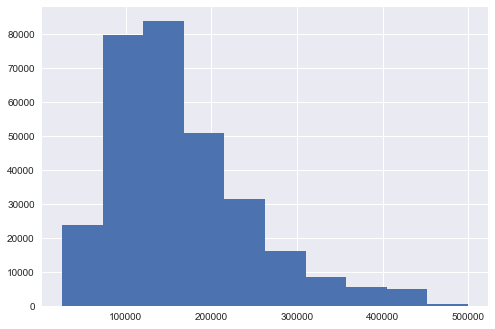

In [654]:
train[num_features[3]].hist()

In [652]:
train[train.target == 1].amt_income_total.max()

990000.0

In [1098]:
X['nan_count'] = X.isna().sum(axis=1)
X['nan_count'] = X['nan_count'].apply(lambda x: 1 if x > 60 else 0)

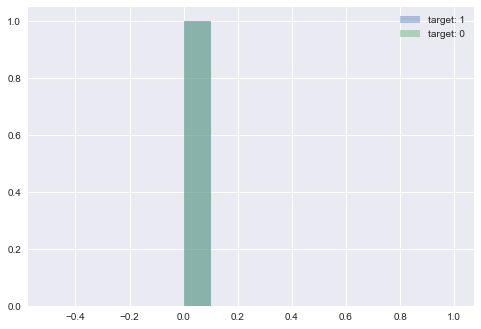

In [1099]:
plt0 = X[(X.dataset == 'train') & (X.target == 0)].nan_count
plt1 = X[(X.dataset == 'train') & (X.target == 1)].nan_count
#plt.title(str(num_features[i]))
hist_print(plt1, plt0)

In [403]:
X_train = X[X.dataset == 'train'].drop(['target', 'dataset'], axis=1)
X_test = X[X.dataset == 'test'].drop(['target', 'dataset'], axis=1)
y_train = X[X.dataset == 'train'].target
y_test = X[X.dataset == 'test'].target

X.drop('dataset', axis=1, inplace=True)

In [404]:
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)
print('X shape:', X.shape)

X_train shape: (252137, 121)
X_test shape: (39470, 121)
y_train shape: (252137,)
y_test shape: (39470,)
X shape: (291607, 122)


In [405]:
num_features = list(X.columns[X.dtypes!=object])
num_features.remove('target')
cat_features = list(X.columns[X.dtypes==object])

In [406]:
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Pipline for numerical features
num_pipeline = Pipeline([
    #('imputer_num', KNNImputer(n_neighbors=2, weights='uniform')),
    ('imputer_num', SimpleImputer(strategy='median')),
    ('std_scaler', StandardScaler())
])

# Pipeline for categorical features 
cat_pipeline = Pipeline([
    ('imputer_cat', SimpleImputer(strategy='constant', fill_value='missing')),
    ('1hot', OneHotEncoder(handle_unknown='ignore'))
])

In [407]:
# Complete pipeline
preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_features),
    ('cat', cat_pipeline, cat_features)
])

In [408]:
# Building a full pipeline with our preprocessor and a LogisticRegression Classifier
pipe_logreg = Pipeline([
    ('preprocessor', preprocessor),
    #('logreg', LogisticRegression(max_iter=1000, class_weight={0:.2, 1:.8}))
    ('classifier', RandomForestClassifier(n_estimators=50))
    #('xgboost', xgb.XGBClassifier(n_estimators=1000, learning_rate=0.05))
])

In [409]:
# Making predictions on the training set using cross validation as well as calculating the probabilities 
y_train_predicted = cross_val_predict(pipe_logreg, X_train, y_train, cv=5, verbose=5)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  2.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  3.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  4.5min finished


In [410]:
# Calculating the accuracy for the LogisticRegression Classifier 
print('Cross validation scores:')
print('-------------------------')
print("Accuracy: {:.2f}".format(accuracy_score(y_train, y_train_predicted)))
print("Recall: {:.2f}".format(recall_score(y_train, y_train_predicted)))
print("Precision: {:.2f}".format(precision_score(y_train, y_train_predicted)))

Cross validation scores:
-------------------------
Accuracy: 0.91
Recall: 0.00
Precision: 0.47


Accuracy: 0.69
Recall: 0.34
Precision: 0.10